In [3]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO
import subprocess as sp
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob, math, re, gzip
import matplotlib.pyplot as plt
import mpltern
import skbio.io

In [4]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return "_".join(gene.split("_")[:-1])
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [5]:
def wrapperize(calls, parts, out):
    n = math.ceil(len(calls)/parts)
    for i in range(0, len(calls),n):
        with open(out + \
            str(int(i/n)+1) + ".sh", "w") as wrapper:
            for call in calls[i:i + n]:
                wrapper.write(call + "\n")

In [6]:
rootdir = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir)

## genomes

### read in metadata

In [19]:
genome_md = pd.read_csv(rootdir + "tables/redundant_genome_info.tsv", sep="\t").query("primary_cluster!='not clustered'")
genome_md.head()

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True
1,TARA_SAMEA2619970_METAG_OGBJMBMB,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,50.57,0.99,2,2_0,True
2,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True
3,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True
4,OceanDNA-b26756,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,73.75,1.47,4,4_1,False


In [20]:
scafdict = {}

for genome in glob.glob(rootdir + "genomes/second_pass/*"):
    name = os.path.basename(genome).replace(".fa", "")
    for record in sfp(open(genome)):
        scafdict[record[0].split(" ")[0]] = name
        
scafdf = pd.DataFrame.from_dict(scafdict, orient="index").reset_index()
scafdf.columns = ["scaffold", "bin"]
scafdf.to_csv(rootdir + "tables/redundant_genome_scaf2bin.tsv", sep="\t", index=False)

scaf2bin = pd.read_csv(rootdir + "tables/redundant_genome_scaf2bin.tsv", sep="\t")
scaf2bin.head()

,scaffold,bin
0,MARD_MMP08886169_SAGS-scaffold_1,MARD_SAMN08886169_SAGS_MMP08886169
1,MARD_MMP08886169_SAGS-scaffold_2,MARD_SAMN08886169_SAGS_MMP08886169
2,MARD_MMP08886169_SAGS-scaffold_3,MARD_SAMN08886169_SAGS_MMP08886169
3,MARD_MMP08886169_SAGS-scaffold_4,MARD_SAMN08886169_SAGS_MMP08886169
4,MARD_MMP08886169_SAGS-scaffold_5,MARD_SAMN08886169_SAGS_MMP08886169


### predict proteins

In [10]:
cmdir(rootdir + "genomes/prodigal")

In [11]:
prodigals = []

for key, row in genome_md.iterrows():
    
    gpath = rootdir + "genomes/second_pass/%s.fa" %(row["genome"])
    outbase = rootdir + "genomes/prodigal/%s.genes" %(row["genome"])
    call = "prodigal -d %s -a %s -i %s -p single" %(outbase + ".fna", outbase + ".faa", gpath)
    prodigals.append(call)

wrapperize(prodigals, 20, rootdir + "genomes/prodigal/prodigal")

In [14]:
with open(rootdir + "genomes/prodigal/submit_all_prodigals.sh", "w") as out:
    
    for prod_file in glob.glob(rootdir + "genomes/prodigal/prodigal*sh"):
        
        # get basename for the job
        name = os.path.basename(prod_file).split(".")[0]
        # make the file executable
        sp.call("chmod +x %s" %(prod_file), shell=True)
        # finally, construct the sbatch command
        cmd = sbatch(name, 1, prod_file)
        # and write that out to the metascript
        out.write(cmd + "\n")

In [15]:
command = "rclone copy %s drive:deepeco/prodigal --progress" %(rootdir + "genomes/prodigal")
print(command)

rclone copy /scratch/users/ajaffe/deepeco/genomes/prodigal drive:deepeco/prodigal --progress


### examine clustering

In [16]:
cmdir(rootdir + "figures")

In [17]:
cluster_info = defaultdict(list)

for secondary_cluster in genome_md["secondary_cluster"].unique():
    
    genomes = genome_md[genome_md["secondary_cluster"]==secondary_cluster]["genome"].to_list()
    
    sources = []
    for genome in genomes:
        if "OceanDNA" in genome:
            sources.append("odna")
        elif genome.startswith("OC"):
            sources.append("oc17")
        else: sources.append("omd")
            
    cluster_info["cluster"].append(secondary_cluster)
    cluster_info["size"].append(len(genomes))
    for source in ["odna", "oc17", "omd"]:
        n = sources.count(source)
        cluster_info[source].append(float(n/len(sources))*100)
    
cluster_df = pd.DataFrame(cluster_info)
cluster_df.head()

,cluster,size,odna,oc17,omd
0,1_0,1,100.0,0.0,0.0
1,2_0,1,0.0,0.0,100.0
2,3_0,1,100.0,0.0,0.0
3,4_1,2,50.0,0.0,50.0
4,5_1,8,37.5,0.0,62.5


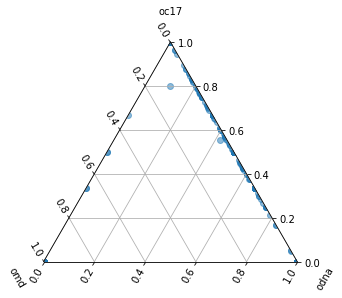

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='ternary')
ax.grid()
pc = ax.scatter(cluster_df["odna"], cluster_df["oc17"], cluster_df["omd"], alpha=0.5)
ax.set_tlabel('oc17')
ax.set_llabel('omd')
ax.set_rlabel('odna')
plt.show()

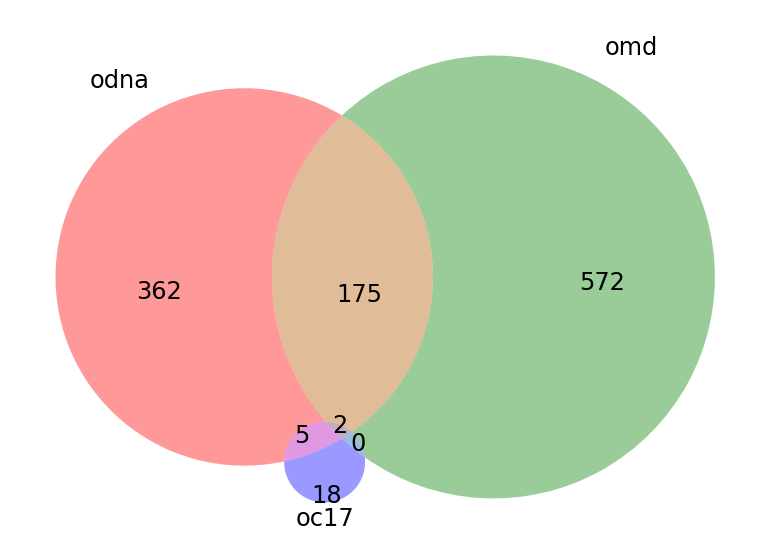

In [19]:
from matplotlib_venn import venn3

plt.figure(figsize=[14,10])
odna = set(cluster_df.query("odna!=0")["cluster"])
omd = set(cluster_df.query("omd!=0")["cluster"])
oc = set(cluster_df.query("oc17!=0")["cluster"])

out = venn3([odna, omd, oc], ('odna', 'omd', 'oc17'))

for text in out.set_labels:
   text.set_fontsize(24)

for text in out.subset_labels:
   text.set_fontsize(24)

plt.savefig(rootdir + "figures/venn.png", format="png", dpi=300)
plt.show()

## rubisco

In [20]:
cmdir(rootdir + "proteins/rubisco")

### hmmsearch + parse

In [46]:
cmdir(rootdir + "proteins/rubisco/hmm_searches")

In [7]:
def parse_domtable(result_table):
    
    temp = {}
    count = 0
    
    for result in SearchIO.parse(result_table, "hmmsearch3-domtab"):
        for item in result.hits:
            hmm_overall_cov = 0
            fragments = []
            for f in item.fragments: # iterate through fragments
                fragments.append(f)
                hmm_overall_cov += (f.query_end-f.query_start)/(result.seq_len)
            n_missing = fragments[0].query_start/result.seq_len # first fragment
            c_missing = (result.seq_len - fragments[-1].query_end)/result.seq_len #last fragment
            temp[count] = {"hmm": result.id.split(".")[0], "gene": item.id, "score": item.bitscore, \
                           "eval": item.evalue, "hmm_n_missing": n_missing, \
                           "hmm_c_missing": c_missing, "hmm_overall_cov": hmm_overall_cov}
            count += 1
            
    return(pd.DataFrame.from_dict(temp, orient="index"))

In [43]:
# write out proteins, removing those from short + bad rubisco scaffold
curated = pd.read_csv(rootdir + "genomes/contigs/diamond/curated.tsv", sep="\t")
scafs_to_remove = curated[(curated["scaffold_len"]<1500) | (curated["misbinned"]==True)]["scaffold"].unique()s

with open(rootdir + "genomes/redundant_genome_protein.faa", "w") as out:
    for proteome in glob.glob(rootdir + "genomes/prodigal/*faa"):
        for record in SeqIO.FastaIO.SimpleFastaParser(open(proteome)):
            scaffold = "_".join(record[0].split(" # ")[0].split("_")[:-1])
            if scaffold not in scafs_to_remove:
                out.write(">%s\n%s\n" %(record[0], record[1]))

140

In [44]:
call = "hmmsearch --cpu 20 --domtblout %s \
            %s %s" %(rootdir + "proteins/rubisco/hmm_searches/rubisco.results",
                     "/home/groups/dekas/ajaffe/hmms/rubisco/rubisco_all_profiles.hmm",
                     rootdir + "genomes/redundant_genome_protein.faa")
print(call)

hmmsearch --cpu 20 --domtblout /scratch/users/ajaffe/deepeco/proteins/rubisco/hmm_searches/rubisco.results             /home/groups/dekas/ajaffe/hmms/rubisco/rubisco_all_profiles.hmm /scratch/users/ajaffe/deepeco/genomes/redundant_genome_protein.faa


In [21]:
hmm_results = parse_domtable(rootdir + "proteins/rubisco/hmm_searches/rubisco.results")
# choose best hmm and filter by hmm cov
hmm_results = hmm_results.sort_values("score", ascending=False).drop_duplicates("gene").query("hmm_overall_cov>0.50")
hmm_results["scaffold"] = hmm_results["gene"].apply(scaffold)
# add in bin name
hmm_results = hmm_results.merge(scaf2bin, how="left", on="scaffold")
# modify hmm names
hmm_results = hmm_results.replace("I_all", "I").replace("IV_all", "IV")
hmm_results.head(2)

,hmm,gene,score,eval,hmm_n_missing,hmm_c_missing,hmm_overall_cov,scaffold,bin
0,I,OceanDNA-b16188_01232_2,991.9,1.600000e-296,0.004264,0.002132,0.993603,OceanDNA-b16188_01232,OceanDNA-b16188
1,I,OceanDNA-b16189_00117_3,991.9,1.600000e-296,0.004264,0.002132,0.993603,OceanDNA-b16189_00117,OceanDNA-b16189


### add back protein and write out

In [51]:
tmp = {record[0].split(" ")[0] : record[1] for record in
           sfp(open(rootdir + "genomes/redundant_genome_protein.faa"))}
hmm_results["sequence"] = hmm_results["gene"].map(tmp)
tmp = []

In [52]:
with open(rootdir + "proteins/rubisco/first_pass_rubisco.faa", "w") as out:
    for key, row in hmm_results.iterrows():
        out.write(">%s\n%s\n" %(row["gene"], row["sequence"]))

### cluster

In [22]:
def parse_usearch_clustering(loc):

    dtypes = {0:'category', 1:'category', 2:np.int32, 8:'object'}
    ucols = [0,1,2,8]
    Rdb = pd.read_csv(loc, header=None, usecols=ucols,\
            dtype=dtypes, sep='\t')
    table = defaultdict(list)

    # Find the centroids
    sdb  = Rdb[Rdb[0] == 'S']
    shdb = Rdb[Rdb[0].isin(['H', 'S'])]
    for centroid, cdb in sdb.groupby(1):
        cent = cdb[8].tolist()[0].split()[0]
        db = shdb[shdb[1] == centroid]

        for seq in db[8].tolist():
            table['cluster'].append(int(centroid))
            table['members'].append(len(db))
            table['sequence'].append(seq.split()[0])
            table['centroid'].append(cent)

    return pd.DataFrame(table)

In [54]:
call = "vsearch --threads 20 --cluster_fast %s --id 0.95 --maxrejects 0 --maxaccepts 0 --centroids %s --uc %s" \
    %(rootdir + "proteins/rubisco/first_pass_rubisco.faa", \
      rootdir + "proteins/rubisco/first_pass_rubisco.centroids.faa", \
      rootdir + "proteins/rubisco/first_pass_rubisco.clusters")
print(call)

vsearch --threads 20 --cluster_fast /scratch/users/ajaffe/deepeco/proteins/rubisco/first_pass_rubisco.faa --id 0.95 --maxrejects 0 --maxaccepts 0 --centroids /scratch/users/ajaffe/deepeco/proteins/rubisco/first_pass_rubisco.centroids.faa --uc /scratch/users/ajaffe/deepeco/proteins/rubisco/first_pass_rubisco.clusters


In [23]:
clusters = parse_usearch_clustering(rootdir + "proteins/rubisco/first_pass_rubisco.clusters")
clusters["cluster_name"] = clusters["cluster"].apply(lambda x: "DPECO_" + str(x))
clusters["is_centroid"] = clusters.apply(lambda x: x["sequence"]==x["centroid"], axis=1)
clusters = clusters[["cluster_name", "members", "sequence", \
                     "is_centroid"]].rename(columns={"sequence":"gene", "members":"cluster_size"})
merged = clusters.merge(hmm_results, on="gene", how="left").fillna("None").drop(["eval", "hmm_n_missing", "hmm_c_missing", "hmm_overall_cov"], axis=1)
merged.head()

,cluster_name,cluster_size,gene,is_centroid,hmm,score,scaffold,bin
0,DPECO_0,1,JASLMP010000001.1_22,True,II_II,705.8,JASLMP010000001.1,GCA_030746445.1_ASM3074644v1_genomic
1,DPECO_1,3,OceanDNA-b32625_00132_3,True,I,321.2,OceanDNA-b32625_00132,OceanDNA-b32625
2,DPECO_1,3,TARA_PSW00024_METAG-scaffold_76_3,False,I,321.2,TARA_PSW00024_METAG-scaffold_76,TARA_SAMN05326646_METAG_PSW00024
3,DPECO_1,3,TARA_SAMEA2622901_METAG-scaffold_22184_2,False,I,321.2,TARA_SAMEA2622901_METAG-scaffold_22184,TARA_SAMEA2622901_METAG_HINFOEKN
4,DPECO_10,4,OceanDNA-b33523_00178_6,True,I,858.6,OceanDNA-b33523_00178,OceanDNA-b33523


### classification - auto

In [24]:
# based on hmm-thresholds
thresholds = {row["hmm"]: row["score_threshold_specific"] for key, row in \
pd.read_csv("/home/groups/dekas/ajaffe/hmms/rubisco/rubisco_thresholds.tsv", sep="\t").iterrows()}

merged["passes_threshold_specific"] = merged.apply(lambda x: x["score"]>=thresholds[x["hmm"]], axis=1)
merged.head(2)

,cluster_name,cluster_size,gene,is_centroid,hmm,score,scaffold,bin,passes_threshold_specific
0,DPECO_0,1,JASLMP010000001.1_22,True,II_II,705.8,JASLMP010000001.1,GCA_030746445.1_ASM3074644v1_genomic,True
1,DPECO_1,3,OceanDNA-b32625_00132_3,True,I,321.2,OceanDNA-b32625_00132,OceanDNA-b32625,False


In [57]:
# based on graftm classification
call = "graftM graft --threads 20 --graftm_package %s \
        --forward %s --input_sequence_type aminoacid \
        --output_directory %s" %("/home/users/ajaffe/misc/graftm_gpkg/rubisco_superfamily.gpkg/",
                                 rootdir + "proteins/rubisco/first_pass_rubisco.faa",
                                 rootdir + "proteins/rubisco/secondary_graftm")
print(call)

graftM graft --threads 20 --graftm_package /home/users/ajaffe/misc/graftm_gpkg/rubisco_superfamily.gpkg/         --forward /scratch/users/ajaffe/deepeco/proteins/rubisco/first_pass_rubisco.faa --input_sequence_type aminoacid         --output_directory /scratch/users/ajaffe/deepeco/proteins/rubisco/secondary_graftm


In [25]:
graft_results = pd.read_csv(rootdir + "proteins/rubisco/secondary_graftm/first_pass_rubisco/" + \
                            "first_pass_rubisco_read_tax.tsv", sep="\t", header=None)
graft_results.columns = ["gene", "graftm_placement"]
merged = merged.merge(graft_results, how="left", on="gene")
merged.head(2)

,cluster_name,cluster_size,gene,is_centroid,hmm,score,scaffold,bin,passes_threshold_specific,graftm_placement
0,DPECO_0,1,JASLMP010000001.1_22,True,II_II,705.8,JASLMP010000001.1,GCA_030746445.1_ASM3074644v1_genomic,True,Root; Bona_Fide; II; II_graftm_1
1,DPECO_1,3,OceanDNA-b32625_00132_3,True,I,321.2,OceanDNA-b32625_00132,OceanDNA-b32625,False,Root; Bona_Fide


### reconcile - what's left?

In [26]:
def parse_graft_placement(taxstring):
    
    l = taxstring.split("; ")
    
    if len(l) > 2:
        if l[2] in ["I", "IV"]:
            return l[2]
        elif l[2] in ["II", "II_III"]:
            return "_".join([l[2]]*2)
        elif l[2] == "III":
            return "_".join(l[2:4])
        else: return taxstring
    else: return taxstring

In [27]:
merged["graft_placement_parsed"] = merged["graftm_placement"].apply(parse_graft_placement)
# grab those where best hmm does not match graft placement, or not entirely
odd_clusters = merged[merged["hmm"]!=merged["graft_placement_parsed"]]["cluster_name"].unique()
print(len(odd_clusters))

60


### classification - manual

In [71]:
cmdir(rootdir + "proteins/rubisco/trees/")

In [309]:
with open(rootdir + "proteins/rubisco/trees/build.sh", "w") as out:
    
    tdir = rootdir + "proteins/rubisco/trees/"
    ref = "/home/groups/dekas/ajaffe/trees/review_subset.faa"
    
    for odd_cluster in ["DPECO_210"]: #odd_clusters:
        
        table = merged[merged["cluster_name"]==odd_cluster]
        faaname = tdir + odd_cluster + ".faa"
        with open(faaname, "w") as faa:
            for key, row in table.iterrows():
                faa.write(">%s\n%s\n" %("_".join([row["gene"], \
                    row["cluster_name"]]), row["sequence"]))
            for record in sfp(open(ref)):
                faa.write(">%s\n%s\n" %(record[0], record[1]))
        
        mafft = "mafft --thread 20 --auto %s > %s" %(faaname, faaname.replace("faa", "mafft"))
        trimal = "trimal -gt 0.1 -in %s -out %s" %(faaname.replace("faa", "mafft"), \
                                                   faaname.replace("faa", "trimal"))
        tree = "FastTreeMP %s > %s" %(faaname.replace("faa", "trimal"), faaname.replace("faa", "tre"))
        out.write(sbatch("tree", 20, " && ".join([mafft, trimal, tree])) + "\n")

In [82]:
# curation out
merged[merged["cluster_name"].isin(odd_clusters)][["cluster_name", "cluster_size", \
                                "gene", "hmm", "score", "graftm_placement"]].to_csv(rootdir + "proteins/rubisco/rbcl_to_curate.tsv", sep="\t", index=False)

In [28]:
# curation in
curated = {row["gene"]:row["curated_rubisco_form"] for key, row in \
              pd.read_csv(rootdir + "proteins/rubisco/rbcl_curated.tsv", sep="\t").iterrows()}
merged["curated_rubisco_form"] = merged.apply(lambda x: x["hmm"] if x["gene"] not in curated.keys() else curated[x["gene"]], axis=1)
merged["curated_rubisco_form"].value_counts()

I                2473
II_II             717
IV                701
III_B             270
III_A             114
III_Like           59
II_III_II_III      20
III_UNK            13
III_C               5
Name: curated_rubisco_form, dtype: int64

### how conserved is rubisco among clusters ?

In [29]:
genomes_wgenes = genome_md.merge(merged[["bin", "curated_rubisco_form"]], how="left", \
                               left_on="genome", right_on="bin").drop("bin", axis=1).fillna("None")

counts = 0
for primary_cluster in genomes_wgenes["primary_cluster"].unique():
    
    genomes_in_cluster = genomes_wgenes[genomes_wgenes["primary_cluster"]==primary_cluster]["genome"].unique()
    
    combos = []
    for genome in genomes_in_cluster:
        genome_rubisco_genes = genomes_wgenes[genomes_wgenes["genome"]==genome]["curated_rubisco_form"].unique()
        combos.append(",".join(sorted(list(genome_rubisco_genes))))
        
    combos_clean = [combo for combo in combos if "None" not in combos]
    
    if len(set(combos_clean)) > 1:
        counts +=1
        
print("Only %d primary clusters of %d containing genomes \
    with different rubisco gene sets." %(counts, len(genomes_wgenes["primary_cluster"].unique())))

Only 15 primary clusters of 796 containing genomes     with different rubisco gene sets.


In [30]:
counts = 0
to_resolve = []
rubisco_sets = {}

for secondary_cluster in genomes_wgenes["secondary_cluster"].unique():
    
    genomes_in_cluster = genomes_wgenes[genomes_wgenes["secondary_cluster"]==secondary_cluster]["genome"].unique()
    
    combos = []
    for genome in genomes_in_cluster:
        genome_rubisco_genes = genomes_wgenes[genomes_wgenes["genome"]==genome]["curated_rubisco_form"].unique()
        combos.append(",".join(sorted(list(genome_rubisco_genes))))
        
    combos_clean = [combo for combo in combos if combo !="None"]
    
    if (len(set(combos_clean)) > 1):
        counts +=1
        to_resolve.append(secondary_cluster)
    elif (len(set(combos)) > 1) and ("None" in combos):
        rubisco_sets[secondary_cluster] = combos_clean[0]
    else: rubisco_sets[secondary_cluster] = combos[0]

print("Only %d secondary clusters of %d containing genomes \
    with different rubisco gene sets." %(counts, len(genomes_wgenes["secondary_cluster"].unique())))

Only 14 secondary clusters of 1134 containing genomes     with different rubisco gene sets.


These results suggest that rubisco inventories are conserved among secondary (and even within primary) clusters. Thus, we can assign genome clusters an overall rubisco type that accounts for incompleteness (or total absence) in cluster representatives. Also, for the mapping analysis, if reads are mismapped within primary clusters, it should be to genomes with similar metabolic features relevant for our question.

### assign rubisco sets to nr-clusters

In [31]:
print(to_resolve)

['70_1', '114_1', '114_2', '143_1', '209_1', '255_1', '264_1', '391_1', '676_1', '687_1', '689_2', '695_1', '718_1', '719_1']


In [32]:
# mostly done by the majority rule. smaller clusters be liberal.
resolved = {'70_1':'III_B', '114_1': 'I', '114_2': 'I', '143_1': 'II_II', '209_1':'I,II_II',
           '255_1':'I,II_II', '264_1':'III_B,IV', '391_1':'I,II_II', '676_1': 'I,IV', 
           '687_1': 'I,IV', '689_2': 'I,IV', '695_1':'I,IV', '718_1':'IV', '719_1':'I,IV'}

In [33]:
non_redundant = genome_md.query("representative==True")
non_redundant["scluster_rubisco_set"] = non_redundant["secondary_cluster"].apply(lambda x: \
                                            rubisco_sets[x] if x in rubisco_sets.keys() else resolved[x])
non_redundant.head()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III
1,TARA_SAMEA2619970_METAG_OGBJMBMB,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,50.57,0.99,2,2_0,True,None
2,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III
3,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True,II_II
5,GCA_030739585.1_ASM3073958v1_genomic,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,93.93,1.87,5,5_1,True,III_B


In [34]:
# remove those secondary clusters with no rubisco assignment whatsoever
non_redundant = non_redundant.query("scluster_rubisco_set!='None'")
non_redundant.head()

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III
2,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III
3,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True,II_II
5,GCA_030739585.1_ASM3073958v1_genomic,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,93.93,1.87,5,5_1,True,III_B
13,OceanDNA-b35769,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.16,0.59,6,6_1,True,I


### export

In [377]:
# redundant gene info
merged.to_csv(rootdir + "tables/redundant_rubisco_info.tsv", sep="\t", index=False)
print("rclone copy /scratch/users/ajaffe/deepeco/tables/redundant_rubisco_info.tsv drive:deepeco/tables --progress")

# non-redundant genome info 
non_redundant.to_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t", index=False)
print("rclone copy /scratch/users/ajaffe/deepeco/tables/nonredundant_genome_info.tsv drive:deepeco/tables --progress")

rclone copy /scratch/users/ajaffe/deepeco/tables/redundant_rubisco_info.tsv drive:deepeco/tables --progress
rclone copy /scratch/users/ajaffe/deepeco/tables/nonredundant_genome_info.tsv drive:deepeco/tables --progress


## supp tables

In [62]:
def assign_dataset(genome):
    
    if "OceanDNA" in genome:
        return "OceanDNA MAG Catalog (Nishimura and Yoshizawa 2022)"
    elif genome.startswith("OC"):
        return "OC1703A (PRJNA1054206)"
    elif genome.split("_")[0] in ["TARA", "MARD", "GORG", "BGEO", "MALA", "HOTS", "BATS"]:
        return "Ocean Microbiomics Database (Paoli et al. 2022)"
    elif (genome.startswith("GCA") or genome.startswith("metabat")):
        return "other"
    else: return "OMZ Database (Anstett et al. 2023)"
    
def clean_rubisco_form(form):
    
    cleaned = []
    
    for item in form.split(","):
        if item == "II_II":
            cleaned.append("II")
        elif item == "II_III_II_III":
            cleaned.append("II_III")
        else: cleaned.append(item)

    return ",".join(cleaned)

In [36]:
scafs, binlens = {}, {}

for genome in glob.glob(rootdir + "genomes/second_pass/*"):
    name = os.path.basename(genome).replace(".fa","")
    scaf, binlen= 0,0
    for record in sfp(open(genome)):
        scaf+=1
        binlen+=len(record[1])
    scafs[name] = scaf
    binlens[name] = binlen

In [68]:
non_redundant = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
non_redundant["dataset"] = non_redundant["genome"].apply(assign_dataset)
non_redundant["num_scaffolds"] = non_redundant["genome"].map(scafs)
non_redundant["bin_length"] = non_redundant["genome"].map(binlens)
non_redundant["rubisco_gene_set"] = non_redundant["scluster_rubisco_set"].apply(clean_rubisco_form)
non_redundant[["genome", "dataset", "secondary_cluster", "classification", "checkm_completeness", "checkm_redundancy",
               "bin_length", "num_scaffolds", "rubisco_gene_set"]].rename(columns={"secondary_cluster":"species_group"}).to_csv(rootdir + "tables/table_s2.tsv", sep="\t", index=False)

In [74]:
merged = pd.read_csv(rootdir + "tables/redundant_rubisco_info.tsv", sep="\t")
merged["cluster_numeric"] = merged["cluster_name"].apply(lambda x: int(x.split("_")[1]))
merged[["cluster_name", "cluster_size", "curated_rubisco_form", "cluster_numeric",
        "is_centroid", "gene", "scaffold", "bin", "sequence"]].sort_values("cluster_numeric").drop("cluster_numeric", axis=1).to_csv(rootdir + "tables/table_s3.tsv", sep="\t", index=False)